In [27]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import deque
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET

In [28]:
folder_path_train_2018 = f"./OhioT1DM 2020/2018/train"
ohio_train_file_names_2018 = [f for f in os.listdir(folder_path_train_2018) if os.path.isfile(os.path.join(folder_path_train_2018, f))]

folder_path_test_2018 = f"./OhioT1DM 2020/2018/test"
ohio_test_file_names_2018 = [f for f in os.listdir(folder_path_test_2018) if os.path.isfile(os.path.join(folder_path_test_2018, f))]

folder_path_train_2020 = f"./OhioT1DM 2020/2020/train"
ohio_train_file_names_2020 = [f for f in os.listdir(folder_path_train_2020) if os.path.isfile(os.path.join(folder_path_train_2020, f))]

folder_path_test_2020 = f"./OhioT1DM 2020/2020/test"
ohio_test_file_names_2020 = [f for f in os.listdir(folder_path_test_2020) if os.path.isfile(os.path.join(folder_path_test_2020, f))]

In [29]:
def load_ohio_series_train(path_filename, variate_name, attribute, time_attribue="ts"):
    tree = ET.parse(f"{path_filename}")
    root = tree.getroot()
    for child in root:
        if child.tag == variate_name:
            dates = []
            values = []
            for event in child:
                ts = event.attrib[time_attribue]
                date = pd.to_datetime(ts, format='%d-%m-%Y %H:%M:%S')
                date = date.replace(second=0)
                value = float(event.attrib[attribute])
                dates.append(date)
                values.append(value)
            index = pd.DatetimeIndex(dates)
            series = pd.Series(values, index=index)
            seriesdf = series.reset_index()

            # Rename the columns (optional)
            seriesdf.columns = ['timestamp', 'mg/dl']
            return seriesdf

In [4]:
def create_loocv_splits(train_files_2018, train_files_2020):
    # Create full paths for all files
    paths_2018 = [os.path.join(folder_path_train_2018, f) for f in train_files_2018]
    paths_2020 = [os.path.join(folder_path_train_2020, f) for f in train_files_2020]
    
    # Combine all paths
    all_paths = paths_2018 + paths_2020
    
    # Create splits
    loocv_splits = {}
    
    for i, test_path in enumerate(all_paths):
        # Create a split where current file is test and others are train
        fold_name = f"fold{i+1}"
        loocv_splits[fold_name] = {
            'test': test_path,
            'train': [path for path in all_paths if path != test_path]
        }
    
    # Print summary
    print(f"Created {len(loocv_splits)} LOOCV splits")
    for fold_name, split in loocv_splits.items():
        print(f"\n{fold_name}:")
        print(f"Test file: {os.path.basename(split['test'])}")
        print(f"Number of training files: {len(split['train'])}")
        print("Training files:")
        for train_path in split['train'][:3]:  # Show first 3 training files
            print(f"  {os.path.basename(train_path)}")
        if len(split['train']) > 3:
            print("  ...")
    
    return loocv_splits

# Create the splits
loocv_splits = create_loocv_splits(ohio_train_file_names_2018, ohio_train_file_names_2020)

Created 12 LOOCV splits

fold1:
Test file: 559-ws-training.xml
Number of training files: 11
Training files:
  563-ws-training.xml
  570-ws-training.xml
  575-ws-training.xml
  ...

fold2:
Test file: 563-ws-training.xml
Number of training files: 11
Training files:
  559-ws-training.xml
  570-ws-training.xml
  575-ws-training.xml
  ...

fold3:
Test file: 570-ws-training.xml
Number of training files: 11
Training files:
  559-ws-training.xml
  563-ws-training.xml
  575-ws-training.xml
  ...

fold4:
Test file: 575-ws-training.xml
Number of training files: 11
Training files:
  559-ws-training.xml
  563-ws-training.xml
  570-ws-training.xml
  ...

fold5:
Test file: 588-ws-training.xml
Number of training files: 11
Training files:
  559-ws-training.xml
  563-ws-training.xml
  570-ws-training.xml
  ...

fold6:
Test file: 591-ws-training.xml
Number of training files: 11
Training files:
  559-ws-training.xml
  563-ws-training.xml
  570-ws-training.xml
  ...

fold7:
Test file: 540-ws-training.xml
N

In [5]:
def create_4fold_splits(train_files_2018, train_files_2020):
    # Create full paths for all files
    paths_2018 = [os.path.join(folder_path_train_2018, f) for f in train_files_2018]
    paths_2020 = [os.path.join(folder_path_train_2020, f) for f in train_files_2020]
    
    # Combine all paths
    all_paths = paths_2018 + paths_2020
    total_files = len(all_paths)
    
    # Calculate files per fold (rounded up for the first folds)
    files_per_fold = total_files // 4
    remainder = total_files % 4
    
    # Create splits
    fold_splits = {}
    start_idx = 0
    
    for fold in range(4):
        fold_name = f"fold{fold+1}"
        
        # Calculate number of files for this fold's test set
        if fold < remainder:
            current_fold_size = files_per_fold + 1
        else:
            current_fold_size = files_per_fold
            
        # Get test indices for this fold
        end_idx = start_idx + current_fold_size
        test_indices = list(range(start_idx, end_idx))
        
        # Create test and train sets
        test_files = [all_paths[i] for i in test_indices]
        train_files = [path for i, path in enumerate(all_paths) if i not in test_indices]
        
        # Add to splits dictionary
        fold_splits[fold_name] = {
            'test': test_files,
            'train': train_files
        }
        
        # Update start index for next fold
        start_idx = end_idx
    
    # # Print summary
    # print(f"Created 4-fold cross validation splits")
    # for fold_name, split in fold_splits.items():
    #     print(f"\n{fold_name}:")
    #     print(f"Test files ({len(split['test'])} files):")
    #     for test_path in split['test']:
    #         print(f"  {os.path.basename(test_path)}")
    #     print(f"\nTraining files ({len(split['train'])} files):")
    #     for train_path in split['train'][:3]:  # Show first 3 training files
    #         print(f"  {os.path.basename(train_path)}")
    #     if len(split['train']) > 3:
    #         print("  ...")
    #     print(f"\nTotal files in this fold: {len(split['test']) + len(split['train'])}")
    
    return fold_splits

# Create the 4-fold splits
fold_splits = create_4fold_splits(ohio_train_file_names_2018, ohio_train_file_names_2020)

In [17]:
df_list = []
for fn in loocv_splits['fold10']['train']:
    ohio_df = load_ohio_series_train(fn, "glucose_level", "value")
    df_list.append(ohio_df)
ohiototal_df = pd.concat(df_list, ignore_index=True)

In [18]:
loocv_splits['fold10']['test']

'./OhioT1DM 2020/2020/train\\567-ws-training.xml'

In [19]:
# Convert timestamp to datetime if it's not already
ohiototal_df['timestamp'] = pd.to_datetime(ohiototal_df['timestamp'])

# Sort by timestamp to ensure proper interval calculation
ohiototal_df = ohiototal_df.sort_values('timestamp')

# Calculate time difference between consecutive records
time_diff = ohiototal_df['timestamp'].diff()

# Basic statistics of the intervals
# print("Time interval statistics:")
# print(f"Mean interval: {time_diff.mean()}")
# print(f"Median interval: {time_diff.median()}")
# print(f"Min interval: {time_diff.min()}")
# print(f"Max interval: {time_diff.max()}")

# # Count the frequency of different intervals
# interval_counts = time_diff.value_counts().sort_index()
# print("\nMost common intervals:")
# print(interval_counts.head())


In [20]:
# Sort by timestamp (just to ensure the data is in order)
ohiototal_df = ohiototal_df.sort_values(by='timestamp')

# Convert 'mg/dl' to numpy array
values = ohiototal_df['mg/dl'].values

In [21]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, ConcatDataset

# First, let's separate the series based on large intervals
def split_into_continuous_series(df, max_interval_minutes=30):
    # Ensure DataFrame is sorted by timestamp
    df = df.sort_values('timestamp')
    
    # Calculate time differences
    time_diff = df['timestamp'].diff()
    
    # Find break points where interval > max_interval_minutes
    break_points = time_diff > pd.Timedelta(minutes=max_interval_minutes)
    
    # Create a series ID for each continuous sequence
    series_ids = break_points.cumsum()
    
    # Split the dataframe into list of series
    series_list = []
    for series_id in range(series_ids.max() + 1):
        series = df[series_ids == series_id].copy()
        # Only keep series with enough data points
        if len(series) > past_sequence_length + future_offset:
            series_list.append(series)
    
    return series_list

# Modified TimeSeriesDataset to work with individual series
class TimeSeriesDataset(Dataset):
    def __init__(self, series, past_seq_len, future_offset):
        self.series = series
        self.past_seq_len = past_seq_len
        self.future_offset = future_offset
        self.values = series['mg/dl'].values
        
    def __len__(self):
        return len(self.values) - self.past_seq_len - self.future_offset + 1
    
    def __getitem__(self, idx):
        seq_x = self.values[idx:idx + self.past_seq_len]
        seq_y = self.values[idx + self.past_seq_len + self.future_offset - 1]
        seq_x = seq_x[:, np.newaxis]  # Add feature dimension
        return torch.FloatTensor(seq_x), torch.FloatTensor([seq_y])

# Split data and create datasets
def create_train_val_datasets(series_list, train_ratio=0.8, past_seq_len=7, future_offset=6):
    train_datasets = []
    val_datasets = []
    
    for series in series_list:
        n_samples = len(series)
        n_train = int(n_samples * train_ratio)
        
        if n_train > past_seq_len + future_offset:  # Ensure enough samples for training
            # Split into train and validation
            train_series = series.iloc[:n_train]
            val_series = series.iloc[n_train - past_seq_len - future_offset:]
            
            # Create datasets
            if len(train_series) > past_seq_len + future_offset:
                train_datasets.append(TimeSeriesDataset(train_series, past_seq_len, future_offset))
            if len(val_series) > past_seq_len + future_offset:
                val_datasets.append(TimeSeriesDataset(val_series, past_seq_len, future_offset))
    
    # Combine datasets
    combined_train_dataset = ConcatDataset(train_datasets)
    combined_val_dataset = ConcatDataset(val_datasets)
    
    return combined_train_dataset, combined_val_dataset

# Main execution
# Parameters
past_sequence_length = 12
future_offset = 6
train_ratio = 0.8
batch_size = 64
max_interval_minutes = 10

# Split the dataframe into continuous series
series_list = split_into_continuous_series(ohiototal_df, max_interval_minutes)

# Print information about the split
print(f"Number of continuous series: {len(series_list)}")
print("\nSeries lengths:")
for i, series in enumerate(series_list):
    print(f"Series {i}: {len(series)} samples")

# Create train and validation datasets
train_dataset, val_dataset = create_train_val_datasets(
    series_list,
    train_ratio=train_ratio,
    past_seq_len=past_sequence_length,
    future_offset=future_offset
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Print final dataset sizes
print(f"\nFinal dataset sizes:")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Verify the shapes
for inputs, targets in train_loader:
    print("\nBatch shapes:")
    print(f"Input batch shape: {inputs.shape}")
    print(f"Target batch shape: {targets.shape}")
    break

Number of continuous series: 146

Series lengths:
Series 0: 1610 samples
Series 1: 83 samples
Series 2: 119 samples
Series 3: 1556 samples
Series 4: 17703 samples
Series 5: 1726 samples
Series 6: 434 samples
Series 7: 627 samples
Series 8: 36 samples
Series 9: 70 samples
Series 10: 800 samples
Series 11: 51 samples
Series 12: 169 samples
Series 13: 142 samples
Series 14: 285 samples
Series 15: 142 samples
Series 16: 142 samples
Series 17: 59 samples
Series 18: 69 samples
Series 19: 141 samples
Series 20: 29 samples
Series 21: 25 samples
Series 22: 474 samples
Series 23: 278 samples
Series 24: 142 samples
Series 25: 140 samples
Series 26: 223 samples
Series 27: 142 samples
Series 28: 371 samples
Series 29: 284 samples
Series 30: 3426 samples
Series 31: 37757 samples
Series 32: 383 samples
Series 33: 465 samples
Series 34: 21 samples
Series 35: 368 samples
Series 36: 277 samples
Series 37: 560 samples
Series 38: 142 samples
Series 39: 142 samples
Series 40: 107 samples
Series 41: 70 samp

# Transformer encoder model

In [22]:
import torch
import torch.nn as nn
import numpy as np

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)  # [1, max_len, d_model]
        
    def forward(self, x):
        # x needs to be shape [batch_size, seq_len, d_model]
        # print(x.shape)
        # print(self.encoding[:, :x.size(1), :].shape)
        return x + self.encoding[:, :x.size(1), :].to(x.device)
    
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
        self.activation = nn.ReLU()
    
    def forward(self, src):
        src2 = self.self_attn(src, src, src)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

# Define the Transformer Encoder with input_dim = 1
# class TransformerEncoder(nn.Module):
#     def __init__(self, num_layers, d_model, nhead, input_dim=1, dim_feedforward=2048, dropout=0.1):
#         super(TransformerEncoder, self).__init__()
#         # Initialize attributes
#         self.d_model = d_model
#         self.input_projection = nn.Linear(input_dim, d_model)
#         self.pos_encoder = PositionalEncoding(d_model)
#         encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
#         self.fc_out = nn.Linear(d_model, 1)

#     def forward(self, src):
#         # Assuming src shape: [batch_size, seq_len, input_dim]
#         src = self.input_projection(src) * np.sqrt(self.d_model)  # Convert to [batch_size, seq_len, d_model]
#         src = self.pos_encoder(src)
#         output = self.transformer_encoder(src)
#         output = self.fc_out(output.mean(dim=1))  # Aggregate output
#         return output

In [23]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, nhead, input_dim=1, dim_feedforward=256, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.d_model = d_model
        
        # Positional Encoding (green block in the figure)
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Initial projection of input data
        self.input_projection = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.LayerNorm(d_model)
        )
        
        # Stack of Encoder Layers
        self.encoder_layers = nn.ModuleList([])
        for _ in range(num_layers):
            # Each encoder layer contains:
            layer = nn.ModuleDict({
                # 1. Multi-Head Attention block (yellow in figure)
                'attention': nn.MultiheadAttention(
                    embed_dim=d_model,
                    num_heads=nhead,
                    dropout=dropout,
                    batch_first=True
                ),
                # 2. Add & Norm after attention (yellow in figure)
                'norm1': nn.LayerNorm(d_model),
                
                # 3. Feed Forward block (blue in figure)
                'feed_forward': nn.Sequential(
                    nn.Linear(d_model, dim_feedforward),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                    nn.Linear(dim_feedforward, d_model)
                ),
                # 4. Add & Norm after feed forward (yellow in figure)
                'norm2': nn.LayerNorm(d_model)
            })
            self.encoder_layers.append(layer)
        
        # Fully Connected output layer (orange in figure)
        self.output_layer = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, 1)
        )
        
    def forward(self, src):
        # src shape: [batch_size, seq_len, input_dim]
        
        # Initial projection and positional encoding
        x = self.input_projection(src)
        x = self.pos_encoder(x)
        
        # Process through encoder layers
        for layer in self.encoder_layers:
            # Multi-Head Attention
            attn_output, _ = layer['attention'](x, x, x)
            # Add & Norm (first residual connection)
            x = layer['norm1'](x + attn_output)
            
            # Feed Forward
            ff_output = layer['feed_forward'](x)
            # Add & Norm (second residual connection)
            x = layer['norm2'](x + ff_output)
        
        # Global average pooling over sequence length
        x = x.mean(dim=1)
        
        # Final output projection
        output = self.output_layer(x)
        
        return output

In [24]:
def train_model(model, train_loader, val_loader, num_epochs=200, learning_rate=1e-3):
    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
    
    best_val_loss = float('inf')
    patience = 35  # Increased patience
    patience_counter = 0
    best_model = None
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to('cuda' if torch.cuda.is_available() else 'cpu')
            targets = targets.to('cuda' if torch.cuda.is_available() else 'cpu')
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation phase
        val_loss = evaluate_model(model, val_loader, criterion)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model = model.state_dict().copy()
        else:
            patience_counter += 1
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if epoch % 5 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Train Loss: {train_loss:.6f}, "
                  f"Val Loss: {val_loss:.6f}")
        
        if patience_counter >= patience:
            print("Early stopping triggered")
            break
    
    # Load best model
    if best_model is not None:
        model.load_state_dict(best_model)
    
    return train_losses, val_losses

def evaluate_model(model, data_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to('cuda') if torch.cuda.is_available() else inputs
            targets = targets.to('cuda') if torch.cuda.is_available() else targets
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(data_loader)
    return val_loss

In [25]:
d_model = 512       # Increased from 64
nhead = 4        # Increased from 4
num_layers = 1     # Increased from 2
dim_feedforward = 256
dropout = 0.2      # Increased dropout

# Create data loaders with smaller batch size
batch_size = 64  # Reduced from 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
# Initialize model
model = TransformerEncoder(
    num_layers=num_layers,
    d_model=d_model,
    nhead=nhead,
    input_dim=1,
    dim_feedforward=dim_feedforward,
    dropout=dropout
).to('cuda' if torch.cuda.is_available() else 'cpu')

# Train model
train_losses, val_losses = train_model(model, train_loader, val_loader)

c:\Users\baiyi\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/200], Train Loss: 4084.883323, Val Loss: 3952.516623
Epoch [6/200], Train Loss: 3661.952201, Val Loss: 3954.223270
Epoch [11/200], Train Loss: 3660.340753, Val Loss: 3923.970222
Epoch [16/200], Train Loss: 3652.729064, Val Loss: 3915.068484
Epoch [21/200], Train Loss: 3606.986992, Val Loss: 2379.381720
Epoch [26/200], Train Loss: 1589.698381, Val Loss: 1403.143630
Epoch [31/200], Train Loss: 1515.538442, Val Loss: 1322.719372
Epoch [36/200], Train Loss: 1500.433100, Val Loss: 1354.254520
Epoch [41/200], Train Loss: 1494.740646, Val Loss: 1247.733936
Epoch [46/200], Train Loss: 1490.332877, Val Loss: 1283.814490
Epoch [51/200], Train Loss: 1480.868750, Val Loss: 1248.760195
Epoch [56/200], Train Loss: 1481.889241, Val Loss: 1304.561042
Epoch [61/200], Train Loss: 1409.302103, Val Loss: 1197.999402
Epoch [66/200], Train Loss: 1402.859523, Val Loss: 1212.931860
Epoch [71/200], Train Loss: 1398.748660, Val Loss: 1248.200427
Epoch [76/200], Train Loss: 1368.085173, Val Loss: 1235.9

Root Mean Square Error (RMSE): 30.45
Mean Absolute Error (MAE): 19.82
Mean Absolute Percentage Error (MAPE): 14.95%


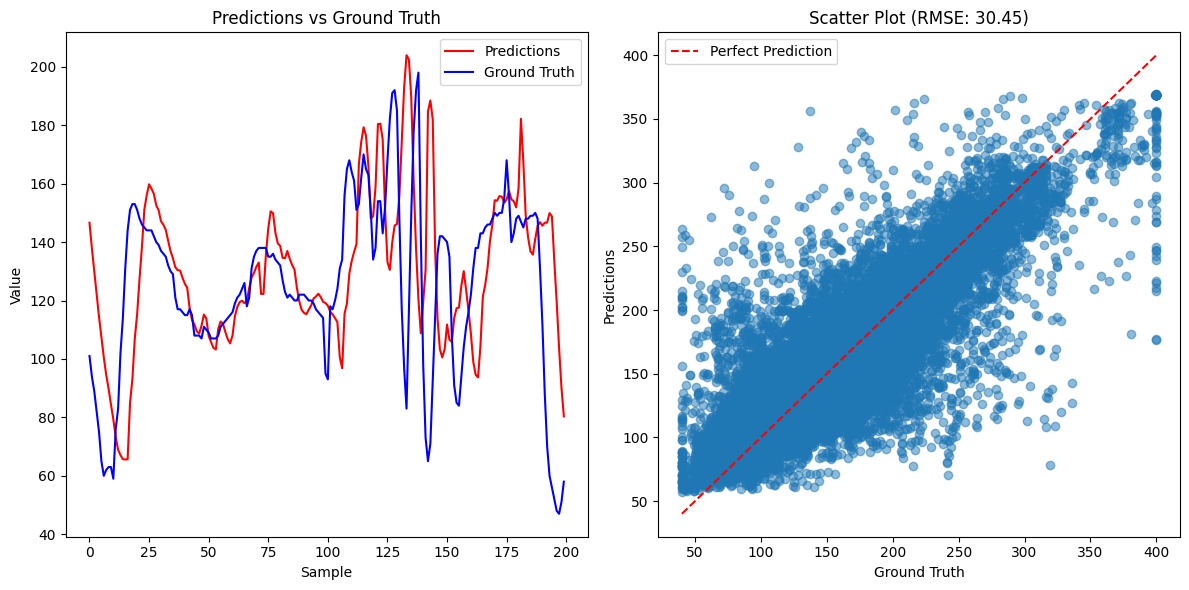

In [16]:
from sklearn.metrics import mean_squared_error
import numpy as np

model.eval()  # Set model to evaluation mode
predictions = []
ground_truths = []

with torch.no_grad():  # Disable gradient computation
    for inputs, targets in val_loader:
        # Move data to GPU if available
        inputs = inputs.to('cuda') if torch.cuda.is_available() else inputs
        targets = targets.to('cuda') if torch.cuda.is_available() else targets
        
        # Get model predictions
        outputs = model(inputs)
        predictions.extend(outputs.cpu().numpy())  # Collect predictions
        ground_truths.extend(targets.cpu().numpy())  # Collect ground truths

# Convert to numpy arrays for plotting
predictions = np.array(predictions).flatten()
ground_truths = np.array(ground_truths).flatten()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(ground_truths, predictions))
print(f'Root Mean Square Error (RMSE): {rmse:.2f}')

# Calculate additional metrics
mae = np.mean(np.abs(predictions - ground_truths))
mape = np.mean(np.abs((ground_truths - predictions) / ground_truths)) * 100

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(predictions[:200], label='Predictions', color='r')
plt.plot(ground_truths[:200], label='Ground Truth', color='b')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Predictions vs Ground Truth')
plt.legend()

# Add scatter plot
plt.subplot(1, 2, 2)
plt.scatter(ground_truths, predictions, alpha=0.5)
plt.plot([min(ground_truths), max(ground_truths)], 
         [min(ground_truths), max(ground_truths)], 
         'r--', label='Perfect Prediction')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title(f'Scatter Plot (RMSE: {rmse:.2f})')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
test_df

,timestamp,mg/dl
0,2021-11-17 12:04:00,128.0
1,2021-11-17 12:09:00,123.0
2,2021-11-17 12:14:00,120.0
3,2021-11-17 12:19:00,124.0
4,2021-11-17 12:24:00,121.0
...,...,...
11861,2022-01-01 23:35:00,223.0
11862,2022-01-01 23:40:00,218.0
11863,2022-01-01 23:45:00,216.0
11864,2022-01-01 23:50:00,216.0


In [16]:
loocv_splits['fold10']['test']

'./OhioT1DM 2020/2020/train\\567-ws-training.xml'

Number of continuous series: 146

Series lengths:
Series 0: 1610 samples
Series 1: 83 samples
Series 2: 119 samples
Series 3: 1556 samples
Series 4: 17703 samples
Series 5: 1726 samples
Series 6: 434 samples
Series 7: 627 samples
Series 8: 36 samples
Series 9: 70 samples
Series 10: 800 samples
Series 11: 51 samples
Series 12: 169 samples
Series 13: 142 samples
Series 14: 285 samples
Series 15: 142 samples
Series 16: 142 samples
Series 17: 59 samples
Series 18: 69 samples
Series 19: 141 samples
Series 20: 29 samples
Series 21: 25 samples
Series 22: 474 samples
Series 23: 278 samples
Series 24: 142 samples
Series 25: 140 samples
Series 26: 223 samples
Series 27: 142 samples
Series 28: 371 samples
Series 29: 284 samples
Series 30: 3426 samples
Series 31: 37757 samples
Series 32: 383 samples
Series 33: 465 samples
Series 34: 21 samples
Series 35: 368 samples
Series 36: 277 samples
Series 37: 560 samples
Series 38: 142 samples
Series 39: 142 samples
Series 40: 107 samples
Series 41: 70 samp

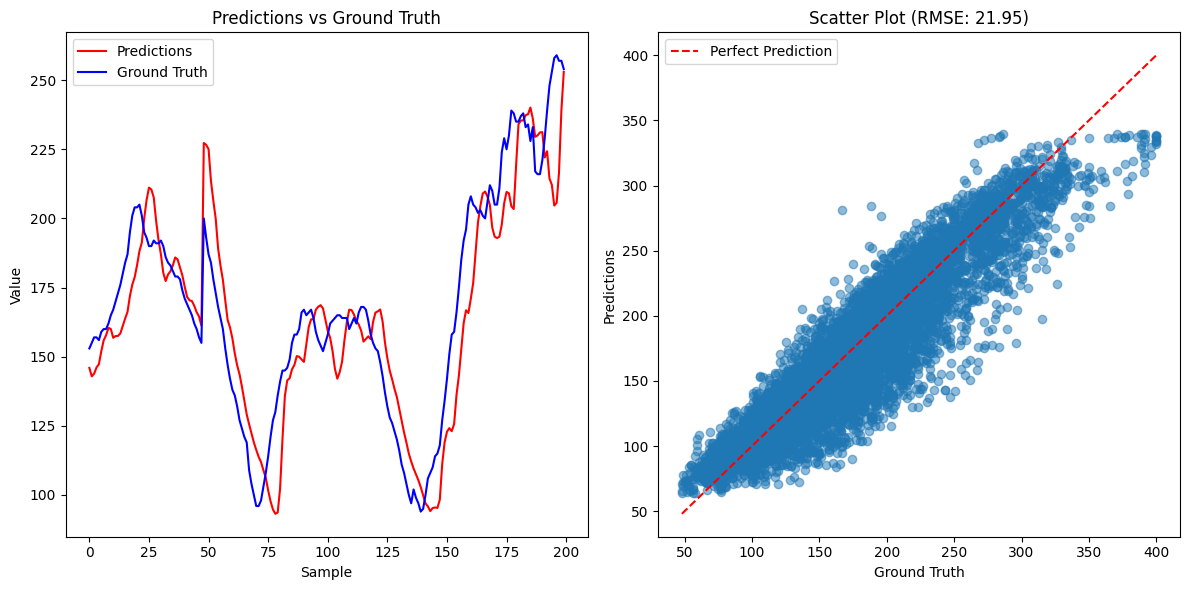

In [26]:
from sklearn.metrics import mean_squared_error
# Load test data (single patient)
test_df = load_ohio_series_train(loocv_splits['fold8']['test'], "glucose_level", "value")
# Convert timestamp to datetime if it's not already
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])

# Sort by timestamp to ensure proper interval calculation
test_df = test_df.sort_values('timestamp')

# Calculate time difference between consecutive records
# time_diff = test_df['timestamp'].diff()
# Sort by timestamp (just to ensure the data is in order)
test_df = test_df.sort_values(by='timestamp')

# Convert 'mg/dl' to numpy array
values = test_df['mg/dl'].values

# Main execution
# Parameters
past_sequence_length = 12
future_offset = 6
train_ratio = 0.8
batch_size = 64
max_interval_minutes = 30

# Split the dataframe into continuous series
test_series_list = split_into_continuous_series(test_df, max_interval_minutes)

# Print information about the split
print(f"Number of continuous series: {len(series_list)}")
print("\nSeries lengths:")
for i, series in enumerate(series_list):
    print(f"Series {i}: {len(series)} samples")

# Create train and validation datasets
test_dataset, test_val_dataset = create_train_val_datasets(
    test_series_list,
    train_ratio=0.99,
    past_seq_len=past_sequence_length,
    future_offset=future_offset
)
# Create data loaders
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


model.eval()  # Set model to evaluation mode
predictions = []
ground_truths = []

with torch.no_grad():  # Disable gradient computation
    for inputs, targets in test_loader:
        # Move data to GPU if available
        inputs = inputs.to('cuda') if torch.cuda.is_available() else inputs
        targets = targets.to('cuda') if torch.cuda.is_available() else targets
        
        # Get model predictions
        outputs = model(inputs)
        predictions.extend(outputs.cpu().numpy())  # Collect predictions
        ground_truths.extend(targets.cpu().numpy())  # Collect ground truths

# Convert to numpy arrays for plotting
predictions = np.array(predictions).flatten()
ground_truths = np.array(ground_truths).flatten()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(ground_truths, predictions))
print(f'Root Mean Square Error (RMSE): {rmse:.2f}')

# Calculate additional metrics
mae = np.mean(np.abs(predictions - ground_truths))
mape = np.mean(np.abs((ground_truths - predictions) / ground_truths)) * 100

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(predictions[:200], label='Predictions', color='r')
plt.plot(ground_truths[:200], label='Ground Truth', color='b')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Predictions vs Ground Truth')
plt.legend()

# Add scatter plot
plt.subplot(1, 2, 2)
plt.scatter(ground_truths, predictions, alpha=0.5)
plt.plot([min(ground_truths), max(ground_truths)], 
         [min(ground_truths), max(ground_truths)], 
         'r--', label='Perfect Prediction')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.title(f'Scatter Plot (RMSE: {rmse:.2f})')
plt.legend()

plt.tight_layout()
plt.show()

Test file: 540-ws-training.xml
Root Mean Square Error (RMSE): 47.14
Mean Absolute Error (MAE): 35.83
Mean Absolute Percentage Error (MAPE): 23.20%


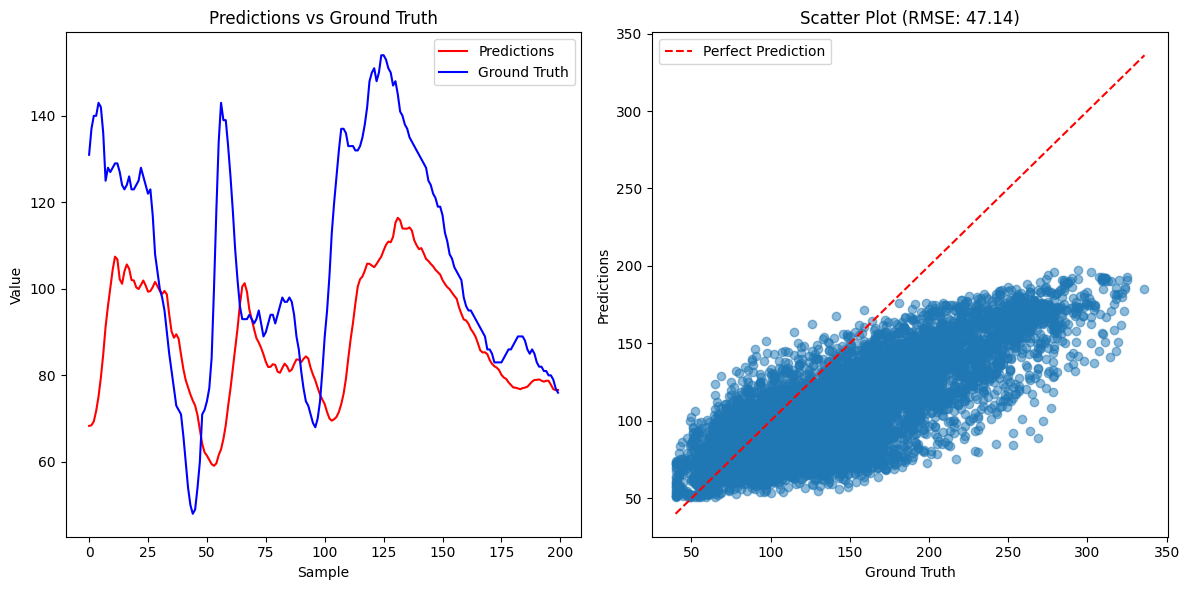

In [42]:
def evaluate_and_save_metrics(model, test_file_path, save_dir="metrics", 
                            past_sequence_length=7, future_offset=6, 
                            batch_size=32, max_interval_minutes=30):
    """
    Evaluate model performance on test data and save metrics to file.
    
    Args:
        model: The trained model
        test_file_path: Path to test file
        save_dir: Directory to save metrics
        past_sequence_length: Length of input sequence
        future_offset: Prediction horizon
        batch_size: Batch size for testing
        max_interval_minutes: Maximum interval between readings to consider continuous
    """
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Load and preprocess test data
    test_df = load_ohio_series_train(test_file_path, "glucose_level", "value")
    test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
    test_df = test_df.sort_values('timestamp')
    
    # Split into continuous series
    test_series_list = split_into_continuous_series(test_df, max_interval_minutes)
    
    # Create dataset and dataloader
    test_dataset, _ = create_train_val_datasets(
        test_series_list,
        train_ratio=0.99,
        past_seq_len=past_sequence_length,
        future_offset=future_offset
    )
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Evaluate model
    model.eval()
    predictions = []
    ground_truths = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to('cuda') if torch.cuda.is_available() else inputs
            targets = targets.to('cuda') if torch.cuda.is_available() else targets
            
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy())
            ground_truths.extend(targets.cpu().numpy())
    
    # Convert to numpy arrays
    predictions = np.array(predictions).flatten()
    ground_truths = np.array(ground_truths).flatten()
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(ground_truths, predictions))
    mae = np.mean(np.abs(predictions - ground_truths))
    mape = np.mean(np.abs((ground_truths - predictions) / ground_truths)) * 100
    
    # Print metrics
    print(f'Test file: {os.path.basename(test_file_path)}')
    print(f'Root Mean Square Error (RMSE): {rmse:.2f}')
    print(f'Mean Absolute Error (MAE): {mae:.2f}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
    
    # Save metrics to file
    metrics_filename = f"metrics_{os.path.basename(test_file_path).split('.')[0]}.txt"
    metrics_path = os.path.join(save_dir, metrics_filename)
    
    with open(metrics_path, 'w') as f:
        f.write(f"Test File: {test_file_path}\n")
        f.write(f"RMSE: {rmse:.2f}\n")
        f.write(f"MAE: {mae:.2f}\n")
        f.write(f"MAPE: {mape:.2f}%\n")
    
    # Create plots
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(predictions[:200], label='Predictions', color='r')
    plt.plot(ground_truths[:200], label='Ground Truth', color='b')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.title('Predictions vs Ground Truth')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.scatter(ground_truths, predictions, alpha=0.5)
    plt.plot([min(ground_truths), max(ground_truths)], 
             [min(ground_truths), max(ground_truths)], 
             'r--', label='Perfect Prediction')
    plt.xlabel('Ground Truth')
    plt.ylabel('Predictions')
    plt.title(f'Scatter Plot (RMSE: {rmse:.2f})')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'predictions': predictions,
        'ground_truths': ground_truths
    }

# Example usage:
test_file = loocv_splits['fold8']['test']
metrics = evaluate_and_save_metrics(
    model=model,
    test_file_path=test_file,
    save_dir='evaluation_metrics'
)